This file takes both the AR6 and SR1.5 databases and finds relationships between the expected (median) warming and the exceedance quantiles for given temperatures. 

It expects to find the metadata for both available in the input folder. These files can be downloaded from 
https://data.ece.iiasa.ac.at/ar6/ and https://data.ene.iiasa.ac.at/iamc-1.5c-explorer/.

In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyam

from labellines import labelLines
from scipy.optimize import curve_fit

<IPython.core.display.Javascript object>

In [2]:
# Define useful parameters for plotting
font = {'family' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

In [3]:
fairexceed2c = 'AR5 climate diagnostics|Temperature|Exceedance Probability|2.0 °C|FAIR'
magiccexceed2c = 'AR5 climate diagnostics|Temperature|Exceedance Probability|2.0 °C|MAGICC6'
fairmed = 'AR5 climate diagnostics|Temperature|Global Mean|FAIR|MED'
magiccmed = 'AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED'
ar6fairexceed2c = 'Exceedance Probability 2.0C (FaIRv1.6.2)'
ar6magiccexceed2c = 'Exceedance Probability 2.0C (MAGICCv7.5.3)'
ar6fairmed = 'Median peak warming (FaIRv1.6.2)'
ar6magiccmed = 'Median peak warming (MAGICCv7.5.3)'

# Import the data and clean it

In [4]:
sr15 = pd.read_excel("./input/iamc15_scenario_data_all_regions_r2.0.xlsx", sheet_name="data")

In [5]:
sr15 = pyam.IamDataFrame(sr15)

In [6]:
ar6meta = pd.read_excel("./input/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx", sheet_name="meta")

In [7]:
ar6meta = ar6meta.loc[ar6meta["Category_Vetting_historical"] != "no-climate-assessment"]

In [8]:
assert ar6meta.index.is_unique

In [9]:
non_numeric_rows = ar6meta[pd.to_numeric(ar6meta[ar6magiccmed], errors='coerce').isna()]
ar6meta = ar6meta.drop(non_numeric_rows.index).reset_index(drop=True)
non_numeric_rows

,Model,Scenario,Category,Category_name,Category_subset,Subset_Ch4,Category_Vetting_historical,IMP_marker,Literature Reference (if applicable),Policy_category,...,P67 peak warming (FaIRv1.6.2),Median warming in 2100 (FaIRv1.6.2),Median year of peak warming (FaIRv1.6.2),Exceedance Probability 1.5C (FaIRv1.6.2),Exceedance Probability 2.0C (FaIRv1.6.2),Exceedance Probability 3.0C (FaIRv1.6.2),IMP_color_rgb,IMP_color_hex,Category_color_rgb,Category_color_hex
165,BET EMF33,EMF33_1.5C_cost100,failed-vetting,failed-vetting,no-climate-assessment,NaN,failed_Vetting_historical_failed-vetting,non-IMP,https://doi.org/10.1007/s10584-020-02945-6; ht...,P2b,...,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,NaN,NaN,"119, 134, 99",778663
166,BET EMF33,EMF33_1.5C_full,failed-vetting,failed-vetting,no-climate-assessment,NaN,failed_Vetting_historical_failed-vetting,non-IMP,https://doi.org/10.1007/s10584-020-02945-6; ht...,P2b,...,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,NaN,NaN,"119, 134, 99",778663
167,BET EMF33,EMF33_1.5C_nofuel,failed-vetting,failed-vetting,no-climate-assessment,NaN,failed_Vetting_historical_failed-vetting,non-IMP,https://doi.org/10.1007/s10584-020-02945-6; ht...,P2b,...,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,NaN,NaN,"119, 134, 99",778663
168,BET EMF33,EMF33_Baseline,failed-vetting,failed-vetting,no-climate-assessment,NaN,failed_Vetting_historical_failed-vetting,non-IMP,https://doi.org/10.1007/s10584-020-02945-6; ht...,P1a,...,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,NaN,NaN,"189, 113, 97",BD7161
169,BET EMF33,EMF33_Med2C_cost100,failed-vetting,failed-vetting,no-climate-assessment,NaN,failed_Vetting_historical_failed-vetting,non-IMP,https://doi.org/10.1007/s10584-020-02945-6; ht...,P2b,...,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,NaN,NaN,"140, 167, 208",8CA7D0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1922,TIAM-ECN MDG 1.1,REF,failed-vetting,failed-vetting,no-climate-assessment,NaN,failed_Vetting_historical_failed-vetting,non-IMP,https://doi.org/10.1080/14693062.2020.1791030,P1,...,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,NaN,NaN,NaN,NaN
1923,TIAM-Grantham 1.0,Baseline,failed-vetting,failed-vetting,no-climate-assessment,NaN,failed_Vetting_historical_failed-vetting,non-IMP,https://doi.org/10.1016/j.energy.2013.01.016,P1d,...,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,NaN,NaN,"241, 136, 114",F18872
1926,TIAM-Grantham 3.2,CO_BAU,failed-vetting,failed-vetting,no-climate-assessment,NaN,failed_Vetting_historical_failed-vetting,non-IMP,https://doi.org/10.1038/s41467-021-26595-z,P1a,...,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,NaN,NaN,NaN,NaN
1951,TIAM-WORLD 1.0,450 concentration,failed-vetting,failed-vetting,no-climate-assessment,NaN,failed_Vetting_historical_failed-vetting,non-IMP,https://doi.org/10.1016/j.eneco.2016.05.005,P2,...,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,no-climate-assessment,NaN,NaN,"167, 198, 130",A7C682


In [10]:
magicc = sr15.filter(variable=[magiccmed, magiccexceed2c]).timeseries().max(axis=1)
fair = sr15.filter(variable=[fairmed, fairexceed2c]).timeseries().max(axis=1)

In [11]:
ar6magicc = ar6meta.loc[:, [ar6magiccexceed2c, ar6magiccmed]]
ar6fair = ar6meta.loc[:, [ar6fairexceed2c, ar6fairmed]]

In [12]:
# Reformat this to have rows as single scenarios with peak values in columns
magicc_pivot = pd.pivot(magicc.reset_index(["variable", "unit"]), columns=["variable"], values=[0])
# get rid of annoying multiindex
magicc_pivot.columns = [x[1] for x in magicc_pivot.columns]
magicc_pivot.head()
# Reformat this to have rows as single scenarios with peak values in columns
fair_pivot = pd.pivot(fair.reset_index(["variable", "unit"]), columns=["variable"], values=[0])
# get rid of annoying multiindex
fair_pivot.columns = [x[1] for x in fair_pivot.columns]
fair_pivot.head()

AR5 climate diagnostics|Temperature|Exceedance Probability|2.0 °C|FAIR  \
model       scenario               region                                                                           
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World                                               0.000                        
            ADVANCE_2020_Med2C     World                                               0.149                        
            ADVANCE_2020_WB2C      World                                               0.012                        
            ADVANCE_2030_Med2C     World                                               0.285                        
            ADVANCE_2030_Price1.5C World                                               0.031                        

                                           AR5 climate diagnostics|Temperature|Global Mean|FAIR|MED  
model       scenario               region                                                            
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World                                               1.243         
            ADVANCE_2020_Med2C     World                                               1.632         
            ADVANCE_2020_WB2C      World                                               1.311         
            ADVANCE_2030_Med2C     World                                               1.778         
            ADVANCE_2030_Price1.5C World                                               1.415

In [13]:
x2s = np.arange(1.2, 4, 0.01)
# We define the logistic function plus a finite offset
def logistic_function(x, L, k, x0, c):
    return L / (1 + np.exp(-k * (x - x0))) + c
def inverse_logistic(y, L, k, x0, c):
    return x0 - 1 / k * (np.log(L / (y - c) - 1))
# Check that we have inverted this correctly
assert np.isclose(x2s, inverse_logistic(logistic_function(x2s, 1.1, 2, 0.5, 5), 1.1, 2, 0.5, 5)).all()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


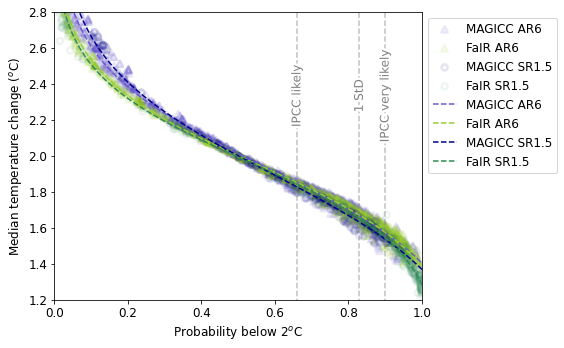

In [14]:
plt.figure(figsize = (8, 5))
edgewidth = 2.5
p0 = [1, 1, 5, 0.0]
xs = np.arange(1.2, 4, 0.01)
fringe = 0.000000005
results = []
interestingProbs = [0.66, 0.83, 0.9]
plotlist = [
        (ar6magicc[ar6magiccexceed2c], ar6magicc[ar6magiccmed], "MAGICC AR6", "slateblue", 0.15, "^"), 
        (ar6fair[ar6fairexceed2c], ar6fair[ar6fairmed], "FaIR AR6", "yellowgreen", 0.14, "^"), 
        (magicc_pivot[magiccexceed2c], magicc_pivot[magiccmed], "MAGICC SR1.5", "darkblue", 0.1, "o"),
        (fair_pivot[fairexceed2c], fair_pivot[fairmed], "FaIR SR1.5", "seagreen", 0.08, "o")
    ]
for x, y, name, color, alpha, marker in plotlist:
    plt.scatter(
        1-x, y, edgecolors=color, facecolors="none", alpha=alpha, marker=marker, label=name, linewidths=edgewidth
    )
for x, y, name, color, alpha, marker in plotlist:
    popt, pcov = curve_fit(logistic_function, y.values, 1-x.values, p0=p0)
    L, k, x0, c = popt
    y_fit = logistic_function(xs, L, k, x0, c)
    results.append(pd.DataFrame({p : inverse_logistic(p, L, k, x0, c) for p in interestingProbs}, index=[name]))
    plt.plot(y_fit, xs, color=(color), label=name, linestyle="--")

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel("Probability below 2$^o$C")
plt.ylabel("Median temperature change ($^o$C)")
for x, label in [(0.66, "IPCC likely"), (0.83, "1 StD"), (0.9, "IPCC very likely")]:
    plt.plot([x, x+fringe], [1, 3], color="grey", linestyle="--", label=label, alpha=0.5)
lines = plt.gca().get_lines()
labelLines(lines[-3:], align=True, xvals=[0.66+fringe*2/3, 0.83+fringe*2/3, 0.90+fringe*2/3])
plt.ylim([1.2, 2.8])
plt.xlim([0, 1])
plt.tight_layout()
plt.savefig("./output/multifitTempProb.png")

In [15]:
results = pd.concat(results)

In [16]:
meanresult = results.loc[["MAGICC SR1.5", "FaIR SR1.5"], :].mean().to_frame().T
meanresult.index = ["SR1.5 mean"]
results = pd.concat([results, meanresult])
results

,0.66,0.83,0.90
MAGICC AR6,1.851920,1.665973,1.573911
FaIR AR6,1.850934,1.670498,1.575885
MAGICC SR1.5,1.827192,1.631201,1.536881
FaIR SR1.5,1.844013,1.653483,1.545889
SR1.5 mean,1.835603,1.642342,1.541385


In [17]:
results.round(3).to_csv("./output/ConversionResults.csv")